# What's Cooking?
### 4X Big Data Project 
#### @ Author's Patricia, Fernanda, Abraham, Mohammed

In [13]:
# Uncomment this for kaggle
#import os
#print(os.listdir("../input"))
import pandas as pd
pd.options.display.max_rows=10
pd.options.display.max_columns=50
import numpy as np
import time
import sklearn
import xgboost as xgb
import seaborn as sns
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import nltk
from collections import Counter
r_state=52
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
print("==================== Packages Loaded ======================")

==================== Packages Loaded ======================


In [2]:
#Uncomment this for kaggle
#train_df = pd.read_json('../input/train.json')
#test_df = pd.read_json('../input/test.json')

train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')

train_df['seperated_ingredients'] = train_df['ingredients'].apply(','.join)
test_df['seperated_ingredients'] = test_df['ingredients'].apply(','.join)

### EDA BEGINS

In [3]:
train_df.head()

,cuisine,id,ingredients,seperated_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,indian,22213,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper..."


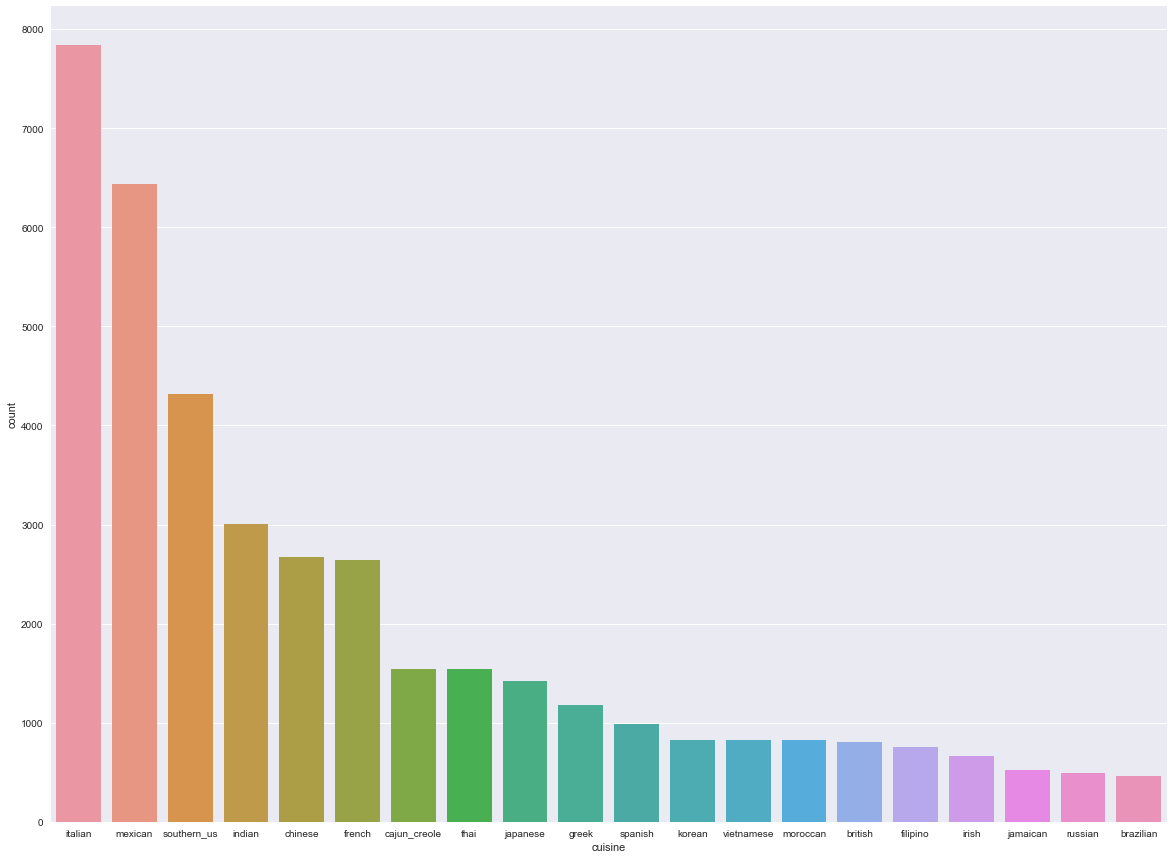

In [4]:
plt.figure(figsize=(20, 15))
#sns.countplot(train_df['cuisine'],orient="categorical")
sns.countplot(x = 'cuisine',
              data = train_df,
              order = train_df['cuisine'].value_counts().index)
plt.show()

In [5]:
print('Maximum Number of Ingredients in a Dish: ',train_df['ingredients'].str.len().max())
print('Average Number of Ingredients in a Dish: ',round(train_df['ingredients'].str.len().mean()))
print('Minimum Number of Ingredients in a Dish: ',train_df['ingredients'].str.len().min())

Maximum Number of Ingredients in a Dish:  65
Average Number of Ingredients in a Dish:  11
Minimum Number of Ingredients in a Dish:  1


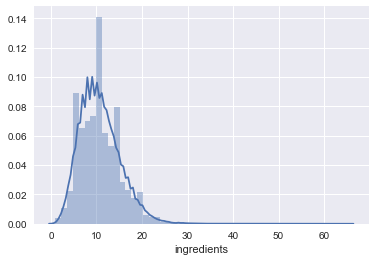

In [6]:
sns.distplot(train_df['ingredients'].str.len())

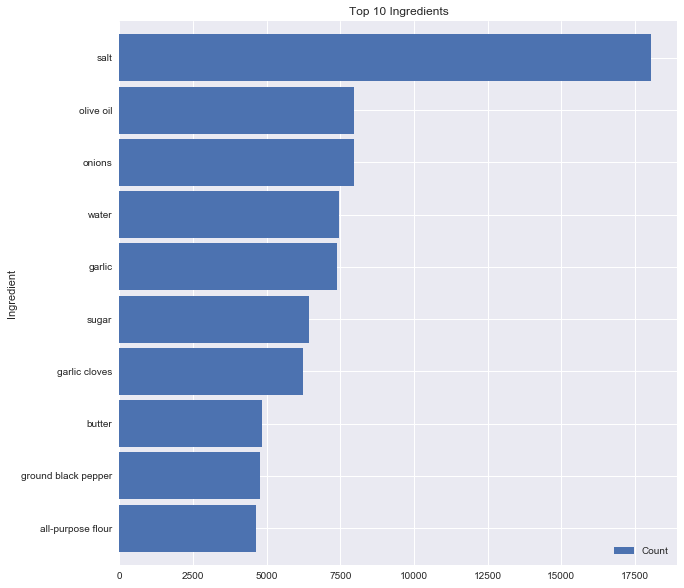

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(tokenizer=lambda x: [i.strip() for i in x.split(',')], lowercase=False)
counts = vec.fit_transform(train_df['seperated_ingredients']) 
count=dict(zip(vec.get_feature_names(), counts.sum(axis=0).tolist()[0]))
count=pd.DataFrame(list(count.items()),columns=['Ingredient','Count'])

count.set_index('Ingredient').sort_values('Count',ascending=False)[:10].plot.barh(width=0.9)
plt.gcf().set_size_inches(10,10)
plt.gca().invert_yaxis()
plt.title('Top 10 Ingredients')

In [9]:
count.shape

(6724, 2)

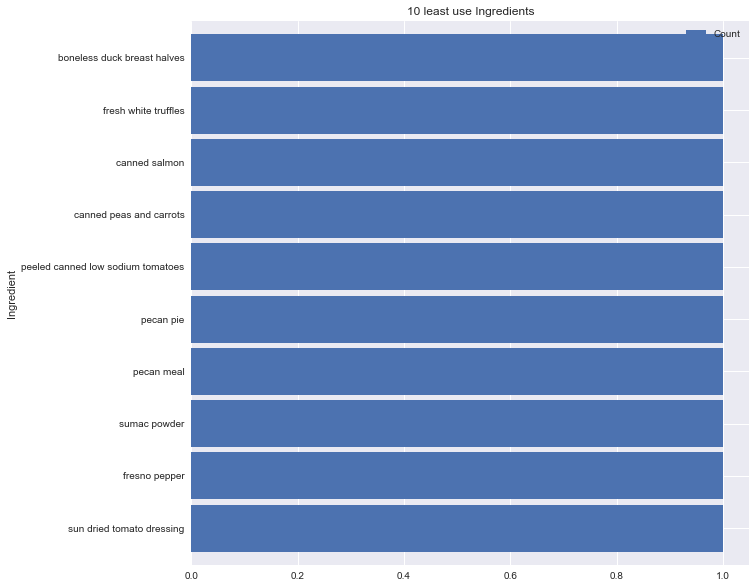

In [11]:
count.set_index('Ingredient').sort_values('Count',ascending=True)[:10].plot.barh(width=0.9)
plt.gcf().set_size_inches(10,10)
plt.gca().invert_yaxis()
plt.title('10 least use Ingredients')

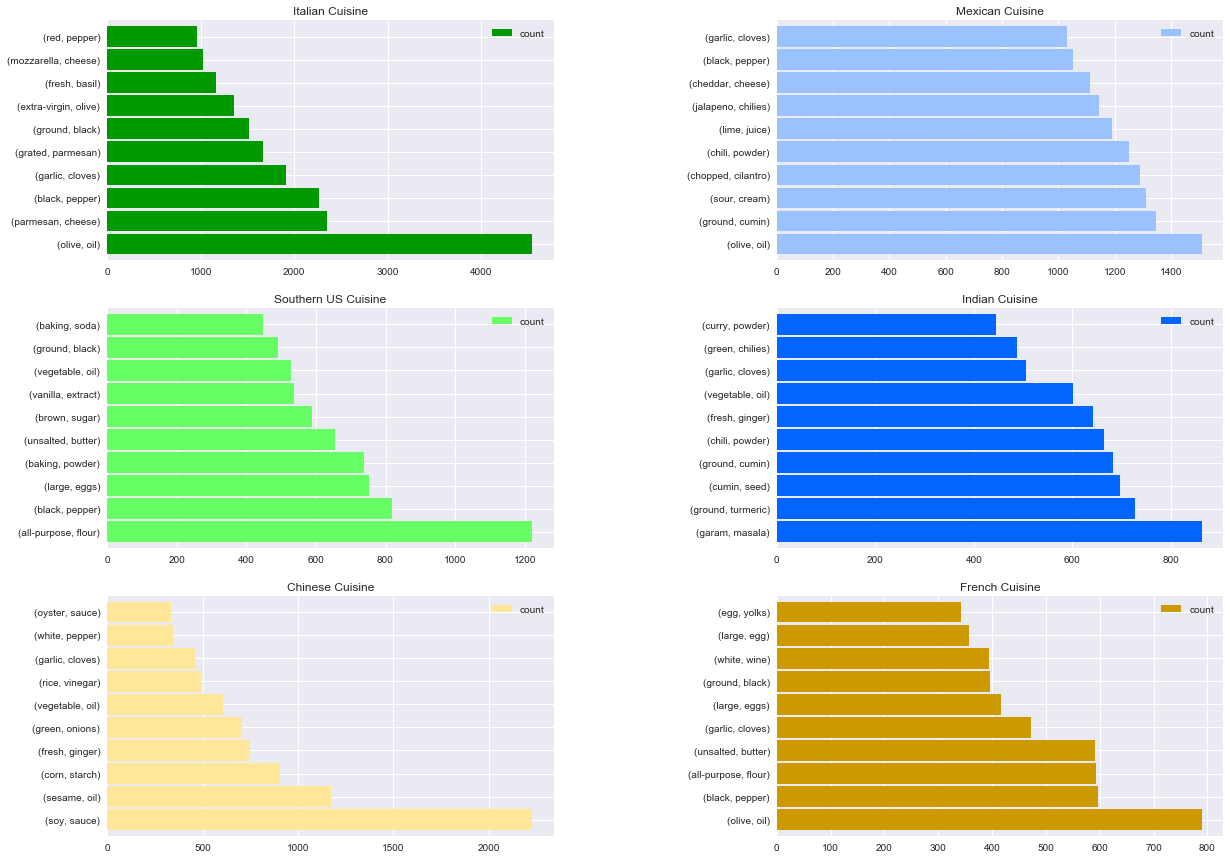

In [27]:
train_df['for ngrams']=train_df['seperated_ingredients'].str.replace(',',' ')
f,ax=plt.subplots(3,2,figsize=(20,15))
def ingre_cusine(cuisine):
    frame=train_df[train_df['cuisine']==cuisine]
    common=list(nltk.bigrams(nltk.word_tokenize(" ".join(frame['for ngrams']))))
    return pd.DataFrame(Counter(common),index=['count']).T.sort_values('count',ascending=False)[:10]

ingre_cusine('italian').plot.barh(ax=ax[0,0],width=0.9,color='#009900')
ax[0,0].set_title('Italian Cuisine')

ingre_cusine('mexican').plot.barh(ax=ax[0,1],width=0.9,color='#99c2ff')
ax[0,1].set_title('Mexican Cuisine')

ingre_cusine('southern_us').plot.barh(ax=ax[1,0],width=0.9,color='#66ff66')
ax[1,0].set_title('Southern US Cuisine')

ingre_cusine('indian').plot.barh(ax=ax[1,1],width=0.9,color='#0066ff')
ax[1,1].set_title('Indian Cuisine')

ingre_cusine('chinese').plot.barh(ax=ax[2,0],width=0.9,color='#ffe699')
ax[2,0].set_title('Chinese Cuisine')

ingre_cusine('french').plot.barh(ax=ax[2,1],width=0.9,color='#cc9900')
ax[2,1].set_title('French Cuisine')

plt.subplots_adjust(wspace=0.5)

### Lets Begin with the modeling 

#### We tried here count vectorizer model, tf idf , however tf idf worked better

In [3]:
# Converting ingredients into a sparse matrix (Using iverse document frequency, because it highlights unique elements)
vect = TfidfVectorizer(binary=True).fit(train_df['seperated_ingredients'].values)
X_train_vectorized = vect.transform(train_df['seperated_ingredients'].values)
X_train_vectorized = X_train_vectorized.astype('float')
Result_transformed = vect.transform(test_df['seperated_ingredients'].values)
Result_transformed = Result_transformed.astype('float')

# Encoding labels
encoder = LabelEncoder()
y_transformed = encoder.fit_transform(train_df.cuisine)

In [4]:
# Splitting data into train test
X_train, X_test, y_train, y_test = train_test_split(X_train_vectorized, y_transformed , random_state = 0)

#### Logistic regression, but whats the best c value?

The top accuracy forecast is 79.5%
Obtained C value = 5.0


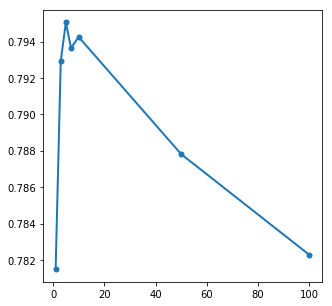

In [5]:
# Logistic regression, which value for C seems best
avg_scores = []
parameter_values = [1,3,5,7,10,50,100]
for mid in parameter_values:
    estimator = LogisticRegression(C=mid)
    estimator.fit(X_train , y_train)
    avg_scores.append(np.mean(estimator.score(X_test, y_test)))

plt.figure(figsize=(5,5))
plt.plot(parameter_values, avg_scores, '-o', linewidth=2, markersize=5)
print("The top accuracy forecast is {0:.1f}%".format(avg_scores[np.argmax(avg_scores)]*100))
print("Obtained C value = {0:.1f}".format(parameter_values[np.argmax(avg_scores)]))

In [ ]:
# Run this block to submit at kaggle
#estimator = LogisticRegression(C=5)
#estimator.fit(X_train , y_train)
#y_predicted = estimator.predict(Result_transformed)
#y_predicted_final = encoder.inverse_transform(y_predicted)
#predictions = pd.DataFrame({'cuisine' : y_predicted_final , 'id' : test_df.id })
#predictions = predictions[[ 'id' , 'cuisine']]
#predictions.to_csv('submit_Logistic.csv', index = False)

#### Can XGBOOST save our lives

In [6]:
# How does XGBOOST perform here?
params = {"objective":"multi:softmax","learning_rate":0.1,"max_depth":200,"subsample":0.2,
          "colsample_bytree":0.5,"seed":r_state,"num_class":20}

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(params=params)

# Fit the classifier to the training set
xg_cl.fit(X_train,y_train)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.734010


#### What about random Forests

In [8]:
# Random Forest
model= RandomForestClassifier(max_depth=500,n_estimators=100,oob_score=True,
                              min_samples_split=5,random_state=r_state,min_samples_leaf=2,criterion='gini',max_features=0.7)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.72043443282381336

#### SVM does the trick

In [9]:
# SVM
vclf=SVC(C=100,gamma=1,kernel='rbf',probability=True)
vclf.fit(X_train , y_train)
vclf.score(X_test, y_test)

0.8128519710378117

In [ ]:
# Uncomment this to submit to kaggle
#y_predicted = vclf.predict(Result_transformed)
#y_predicted_final = encoder.inverse_transform(y_predicted)
#predictions = pd.DataFrame({'cuisine' : y_predicted_final , 'id' : test_df.id })
#predictions = predictions[[ 'id' , 'cuisine']]
#predictions.to_csv('submit_svm.csv', index = False)

#### Neural Networks may save us

In [13]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(1000,kernel_initializer='uniform', activation='relu', input_shape=(3051,)))

model.add(Dense(500,kernel_initializer='uniform', activation='relu'))

model.add(Dense(250,kernel_initializer='uniform', activation='relu'))

model.add(Dense(100,kernel_initializer='uniform', activation='relu'))

# Add an output layer 
model.add(Dense(20, kernel_initializer='uniform',activation='sigmoid'))

In [14]:
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                   
mod=model.fit(X_train, dummy_y,epochs=20, batch_size=64, verbose=1)

Epoch 1/20
29830/29830 [==============================] - 57s 2ms/step - loss: 1.6721 - acc: 0.4513
Epoch 2/20
29830/29830 [==============================] - 56s 2ms/step - loss: 0.8993 - acc: 0.7124
Epoch 3/20
29830/29830 [==============================] - 56s 2ms/step - loss: 0.5628 - acc: 0.8328
Epoch 4/20
29830/29830 [==============================] - 56s 2ms/step - loss: 0.3281 - acc: 0.8998
Epoch 5/20
29830/29830 [==============================] - 56s 2ms/step - loss: 0.1810 - acc: 0.9468
Epoch 6/20
29830/29830 [==============================] - 56s 2ms/step - loss: 0.1011 - acc: 0.9702
Epoch 7/20
29830/29830 [==============================] - 56s 2ms/step - loss: 0.0643 - acc: 0.9819
Epoch 8/20
29830/29830 [==============================] - 56s 2ms/step - loss: 0.0503 - acc: 0.9861
Epoch 9/20
29830/29830 [==============================] - 56s 2ms/step - loss: 0.0430 - acc: 0.9883
Epoch 10/20
29830/29830 [==============================] - 56s 2ms/step - loss: 0.0396 - acc: 0.9882

In [15]:
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y)

scores = model.evaluate(X_test, dummy_y_test,verbose=1)
print(scores)

9944/9944 [==============================] - 5s 455us/step
[2.1429081199059827, 0.75754223647658514]


In [ ]:
# Uncomment to submit to kaggle
#y_predicted = model.predict(Result_transformed)
#predictions = pd.DataFrame({'cuisine' : y_predicted_final , 'id' : test_df.id })
#predictions = predictions[[ 'id' , 'cuisine']]
#predictions.to_csv('submit_NN.csv', index = False)

### Summary
Neural networks performed best on Kaggle, however SVM performed best on my test set